# Model 2: Quality & Confidence Classifier
## Random Forest for Detecting Suspicious Measurements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Quality Dataset

In [2]:
# Load train/val/test splits
train_df = pd.read_csv('quality_train_20260209_220137.csv')
val_df = pd.read_csv('quality_val_20260209_220137.csv')
test_df = pd.read_csv('quality_test_20260209_220137.csv')

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"\nLabel distribution (train):")
print(train_df['confidence_flag'].value_counts())
train_df.head()

Train: 5665 | Val: 1214 | Test: 1214

Label distribution (train):
confidence_flag
SUSPICIOUS    4034
OK            1631
Name: count, dtype: int64


,child_id,visit_date,sex,age_months,muac_mm,edema,appetite,danger_signs,label_pathway,confidence_flag,error_type,near_threshold,unit_suspect,age_suspect
0,CH001154,2023-12-16,M,18.0,114.0,0,good,0,OTP,OK,none,1,0,0
1,CH001059,2022-02-18,F,10.0,120.0,-1,good,0,TSFP,SUSPICIOUS,missing_field,0,0,0
2,CH001216,2022-05-17,M,24.0,110.0,0,good,0,OTP,OK,none,0,0,0
3,CH000441,2024-10-16,F,2.0,116.0,0,good,0,TSFP,SUSPICIOUS,age_error,1,0,1
4,CH002234,2024-01-27,F,32.0,114.0,-1,good,1,SC_ITP,SUSPICIOUS,missing_field,1,0,0


## 2. Feature Engineering

In [3]:
def prepare_features(df):
    """Encode categorical features and select training columns."""
    df = df.copy()
    
    # Encode sex
    df['sex_encoded'] = (df['sex'] == 'M').astype(int)
    
    # Encode appetite
    appetite_map = {'good': 0, 'poor': 1, 'unknown': 2}
    df['appetite_encoded'] = df['appetite'].map(appetite_map).fillna(2)
    
    # Fill missing age with median
    df['age_months'] = df['age_months'].fillna(df['age_months'].median())
    
    # Feature columns
    feature_cols = [
        'muac_mm', 'age_months', 'sex_encoded', 'edema', 
        'appetite_encoded', 'danger_signs',
        'near_threshold', 'unit_suspect', 'age_suspect'
    ]
    
    X = df[feature_cols]
    y = (df['confidence_flag'] == 'SUSPICIOUS').astype(int)  # 1=SUSPICIOUS, 0=OK
    
    return X, y, feature_cols

X_train, y_train, feature_cols = prepare_features(train_df)
X_val, y_val, _ = prepare_features(val_df)
X_test, y_test, _ = prepare_features(test_df)

print(f"Features: {feature_cols}")
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train distribution: OK={sum(y_train==0)}, SUSPICIOUS={sum(y_train==1)}")

Features: ['muac_mm', 'age_months', 'sex_encoded', 'edema', 'appetite_encoded', 'danger_signs', 'near_threshold', 'unit_suspect', 'age_suspect']

X_train shape: (5665, 9)
y_train distribution: OK=1631, SUSPICIOUS=4034


## 3. Train Random Forest

In [4]:
# Train model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
model.fit(X_train, y_train)
print("✓ Training complete")

Training Random Forest...
✓ Training complete


## 4. Evaluate on Validation Set

In [5]:
# Predictions
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

# Metrics
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['OK', 'SUSPICIOUS']))

Validation Accuracy: 0.921

Classification Report:
              precision    recall  f1-score   support

          OK       0.80      0.97      0.88       347
  SUSPICIOUS       0.99      0.90      0.94       867

    accuracy                           0.92      1214
   macro avg       0.89      0.94      0.91      1214
weighted avg       0.93      0.92      0.92      1214



## 5. Confusion Matrix

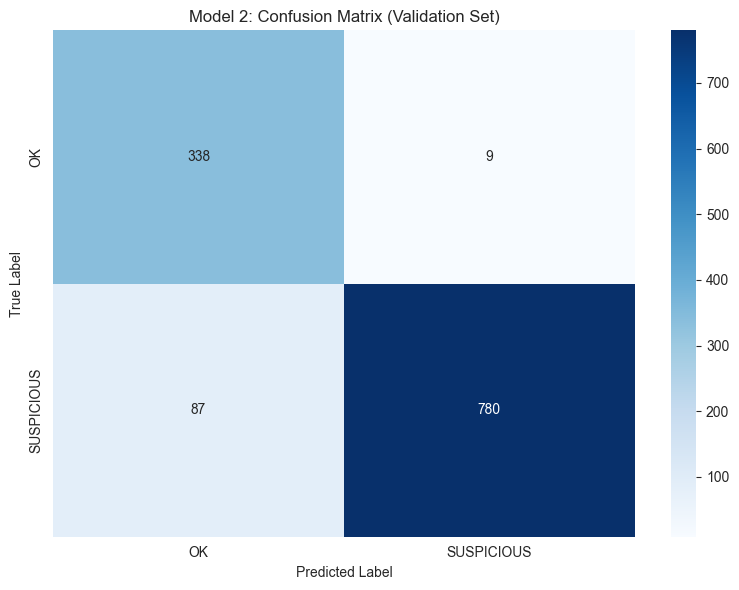

True Negatives (OK→OK): 338
False Positives (OK→SUSPICIOUS): 9
False Negatives (SUSPICIOUS→OK): 87
True Positives (SUSPICIOUS→SUSPICIOUS): 780


In [6]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['OK', 'SUSPICIOUS'], 
            yticklabels=['OK', 'SUSPICIOUS'])
plt.title('Model 2: Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model2_confusion_matrix.png', dpi=300)
plt.show()

print(f"True Negatives (OK→OK): {cm[0,0]}")
print(f"False Positives (OK→SUSPICIOUS): {cm[0,1]}")
print(f"False Negatives (SUSPICIOUS→OK): {cm[1,0]}")
print(f"True Positives (SUSPICIOUS→SUSPICIOUS): {cm[1,1]}")

## 6. Feature Importance

/var/folders/hd/0yz07vv55kqdsst_r4n3z1d00000gn/T/ipykernel_85240/2428831413.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


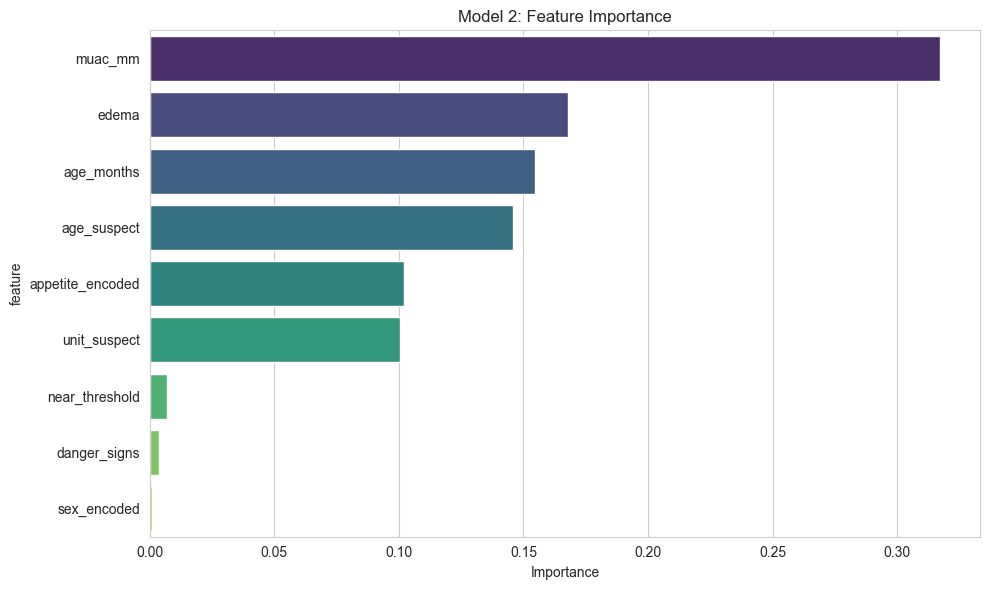

            feature  importance
0           muac_mm    0.317412
3             edema    0.167878
1        age_months    0.154737
8       age_suspect    0.145689
4  appetite_encoded    0.102060
7      unit_suspect    0.100467
6    near_threshold    0.006839
5      danger_signs    0.003842
2       sex_encoded    0.001076


In [7]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Model 2: Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('model2_feature_importance.png', dpi=300)
plt.show()

print(importance_df)

## 7. Test Set Evaluation

In [8]:
# Final test
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['OK', 'SUSPICIOUS']))

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  OK→OK: {cm_test[0,0]} | OK→SUSPICIOUS: {cm_test[0,1]}")
print(f"  SUSPICIOUS→OK: {cm_test[1,0]} | SUSPICIOUS→SUSPICIOUS: {cm_test[1,1]}")

FINAL TEST SET RESULTS

Test Accuracy: 0.892

Classification Report:
              precision    recall  f1-score   support

          OK       0.73      0.97      0.83       335
  SUSPICIOUS       0.99      0.86      0.92       879

    accuracy                           0.89      1214
   macro avg       0.86      0.92      0.88      1214
weighted avg       0.92      0.89      0.90      1214


Confusion Matrix:
  OK→OK: 325 | OK→SUSPICIOUS: 10
  SUSPICIOUS→OK: 121 | SUSPICIOUS→SUSPICIOUS: 758


## 8. Error Analysis

In [9]:
# Analyze misclassifications
test_df_copy = test_df.copy()
test_df_copy['predicted'] = ['SUSPICIOUS' if p == 1 else 'OK' for p in y_test_pred]
test_df_copy['correct'] = (y_test == y_test_pred)

# False negatives (SUSPICIOUS predicted as OK) - DANGEROUS
false_negatives = test_df_copy[(test_df_copy['confidence_flag'] == 'SUSPICIOUS') & 
                                (test_df_copy['predicted'] == 'OK')]

print(f"False Negatives (missed errors): {len(false_negatives)}")
if len(false_negatives) > 0:
    print(f"\nError types missed:")
    print(false_negatives['error_type'].value_counts())
    print(f"\nSample false negatives:")
    print(false_negatives[['muac_mm', 'age_months', 'error_type', 'unit_suspect', 'age_suspect']].head())

False Negatives (missed errors): 121

Error types missed:
error_type
noise            72
missing_field    49
Name: count, dtype: int64

Sample false negatives:
    muac_mm  age_months     error_type  unit_suspect  age_suspect
4     116.0         NaN  missing_field             0            0
25    115.0         NaN  missing_field             0            0
37    109.0        26.0          noise             0            0
39    102.0        31.0          noise             0            0
42    120.0        38.0          noise             0            0


## 9. Save Model

In [10]:
# Save model
model_path = 'model2_quality_classifier.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved: {model_path}")

# Save feature names
import json
metadata = {
    'model_type': 'RandomForestClassifier',
    'target': 'confidence_flag (OK=0, SUSPICIOUS=1)',
    'features': feature_cols,
    'train_samples': len(X_train),
    'val_accuracy': float(val_acc),
    'test_accuracy': float(test_acc),
    'n_estimators': 100,
    'max_depth': 10
}

with open('model2_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: model2_metadata.json")

✓ Model saved: model2_quality_classifier.pkl
✓ Metadata saved: model2_metadata.json


## 10. Test Inference Example

In [11]:
# Example: Test with new data
def check_quality(muac_mm, age_months, sex, edema, appetite, danger_signs):
    """Check if measurement is OK or SUSPICIOUS."""
    
    # Derived features
    near_threshold = 1 if 113 <= muac_mm <= 117 else 0
    unit_suspect = 1 if muac_mm < 50 or muac_mm > 200 else 0
    age_suspect = 1 if age_months < 6 or age_months > 59 else 0
    
    # Encode
    sex_encoded = 1 if sex == 'M' else 0
    appetite_map = {'good': 0, 'poor': 1, 'unknown': 2}
    appetite_encoded = appetite_map.get(appetite, 2)
    
    # Create feature vector
    X = np.array([[
        muac_mm, age_months, sex_encoded, edema, 
        appetite_encoded, danger_signs,
        near_threshold, unit_suspect, age_suspect
    ]])
    
    # Predict
    pred = model.predict(X)[0]
    proba = model.predict_proba(X)[0]
    
    result = 'SUSPICIOUS' if pred == 1 else 'OK'
    confidence = proba[pred]
    
    return result, confidence

# Test cases
print("="*70)
print("INFERENCE EXAMPLES")
print("="*70)

test_cases = [
    (114, 24, 'M', 0, 'good', 0, "Normal measurement"),
    (11.4, 24, 'M', 0, 'good', 0, "Unit error (mm→cm)"),
    (114, 240, 'M', 0, 'good', 0, "Age error (×10)"),
    (145, 24, 'M', 3, 'good', 0, "Impossible combo"),
    (95, 24, 'M', 0, 'good', 0, "Borderline low MUAC"),
]

for muac, age, sex, edema, appetite, danger, desc in test_cases:
    result, conf = check_quality(muac, age, sex, edema, appetite, danger)
    print(f"\n{desc}:")
    print(f"  Input: MUAC={muac}, age={age}, sex={sex}")
    print(f"  → {result} (confidence: {conf:.2%})")

INFERENCE EXAMPLES

Normal measurement:
  Input: MUAC=114, age=24, sex=M
  → OK (confidence: 78.60%)

Unit error (mm→cm):
  Input: MUAC=11.4, age=24, sex=M
  → SUSPICIOUS (confidence: 100.00%)

Age error (×10):
  Input: MUAC=114, age=240, sex=M
  → SUSPICIOUS (confidence: 100.00%)

Impossible combo:
  Input: MUAC=145, age=24, sex=M
  → SUSPICIOUS (confidence: 100.00%)

Borderline low MUAC:
  Input: MUAC=95, age=24, sex=M
  → SUSPICIOUS (confidence: 68.94%)


/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/skl

## Summary

**Model 2 (Quality Classifier) is trained!**

- ✓ Detects suspicious measurements (OK vs SUSPICIOUS)
- ✓ Trained on 5,665 samples (2,313 clean + 5,780 corrupted)
- ✓ Random Forest with 100 trees
- ✓ Ready for deployment as quality gatekeeper

**Next steps:**
1. Export to ONNX/TFLite for mobile
2. Integrate into app before Model 1
3. Collect real field corrections for retraining